In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df=pd.read_csv('../Unbalanced_Dataset.csv',index_col=0)
test_set=pd.read_csv('../testset.csv',index_col=0)

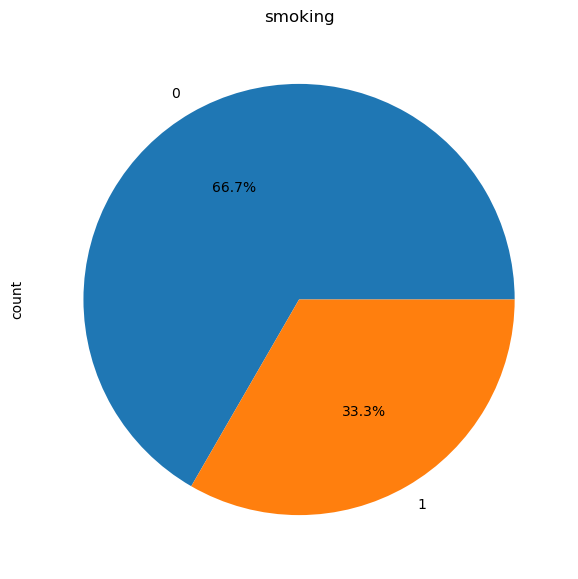

In [3]:
fig, axes = plt.subplots(figsize=(7, 7))
df['smoking'].value_counts().plot.pie(autopct='%1.1f%%')
axes.set_title('smoking')
plt.show()

In [4]:
train_copy=df.drop('id',axis=1)
X = train_copy.drop('smoking', axis=1)
y = train_copy['smoking']

test_set=test_set.drop('id',axis=1)
X_test= test_set.drop('smoking', axis=1)
y_test = test_set['smoking']

In [6]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=20)
    max_depth = trial.suggest_int('max_depth', 5, 25)
    max_features = trial.suggest_int('max_features', 3, 15)
    # min_samples_split = trial.suggest_int('min_samples_split', 10, 100)
    # min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 50)

    scores = []
    F1=[]

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # scaler = MinMaxScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_val_scaled = scaler.transform(X_val)

        
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=42,
            n_jobs=-1,
            # min_samples_split=min_samples_split,
            # min_samples_leaf=min_samples_leaf

            
        )


        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        F1c=f1_score(y_val, y_pred, average='macro') 
        F1.append(F1c)


        y_pred_train = rf.predict(X_train)
        acc_train = accuracy_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train, average='macro')

        overfit_penalty = abs(acc_train - acc)

        #scores.append(acc)
        score = 0.5 * acc - 0.5 * overfit_penalty


        scores.append(score)


    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=20)  


print("best_params:", study.best_params)
print(f"best_value: {study.best_value:.4f}")

[I 2025-08-11 15:09:19,370] A new study created in memory with name: no-name-27956f70-b1a3-4553-a519-695885751d96
[I 2025-08-11 15:09:25,938] Trial 0 finished with value: 0.26433333333333336 and parameters: {'n_estimators': 240, 'max_depth': 24, 'max_features': 12}. Best is trial 0 with value: 0.26433333333333336.
[I 2025-08-11 15:09:28,831] Trial 1 finished with value: 0.35456666666666664 and parameters: {'n_estimators': 340, 'max_depth': 8, 'max_features': 5}. Best is trial 1 with value: 0.35456666666666664.
[I 2025-08-11 15:09:31,753] Trial 2 finished with value: 0.26200000000000007 and parameters: {'n_estimators': 120, 'max_depth': 23, 'max_features': 10}. Best is trial 1 with value: 0.35456666666666664.
[I 2025-08-11 15:09:36,243] Trial 3 finished with value: 0.37069166666666675 and parameters: {'n_estimators': 380, 'max_depth': 5, 'max_features': 15}. Best is trial 3 with value: 0.37069166666666675.
[I 2025-08-11 15:09:40,219] Trial 4 finished with value: 0.34265833333333334 and 

best_params: {'n_estimators': 220, 'max_depth': 5, 'max_features': 13}
best_value: 0.3708


In [7]:
rf_final = RandomForestClassifier(
           n_estimators=220,
            max_depth=5,
            max_features=13,
            random_state=42,
            # min_samples_split=43,
            # min_samples_leaf=25
)
rf_final.fit(X, y)  

y_test_pred = rf_final.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

train_pred = rf_final.predict(X)  
train_acc = accuracy_score(y, train_pred)
print(f"Train Accuracy: {train_acc:.4f}, test Accuracy: {acc_test:.4f}")

print(f"Test Accuracy:  {acc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")
print(f"Test F1 Score:  {f1_test:.4f}")
print("\n RF Test set classification report:")
print(classification_report(y_test, y_test_pred, digits=4))

Train Accuracy: 0.7652, test Accuracy: 0.7450
Test Accuracy:  0.7450
Test Precision: 0.7514
Test Recall:    0.7450
Test F1 Score:  0.7434

 RF Test set classification report:
              precision    recall  f1-score   support

           0     0.7112    0.8250    0.7639      1000
           1     0.7917    0.6650    0.7228      1000

    accuracy                         0.7450      2000
   macro avg     0.7514    0.7450    0.7434      2000
weighted avg     0.7514    0.7450    0.7434      2000



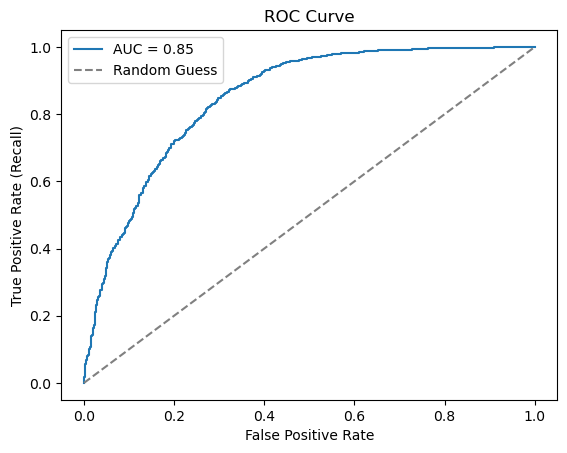

In [8]:
y_test_proba = rf_final.predict_proba(X_test)[:, 1]  


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
y_true = y_test.values  

y_score_rf = rf_final.predict_proba(X_test)[:, 1]

df_rf = pd.DataFrame({
    "y_true": y_true.flatten(),  
    "rf": y_score_rf
})
# df_rf.to_csv("../roc_scores_rf.csv", index=False)
print("saved:::roc_scores_rf.csv")

saved:::roc_scores_rf.csv


In [ ]:
import joblib
joblib.dump(rf_final, "rf_model.pkl")


In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # scaler = MinMaxScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.transform(X_val)

    rf = RandomForestClassifier(
            n_estimators=220,
            max_depth=5,
            max_features=13,
            random_state=42,
            # min_samples_split=43,
            # min_samples_leaf=25
        )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Fold {fold + 1}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("-" * 30)

    train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {acc:.4f}")
    print(f"Fold {fold + 1} Classification Report:")
    print(classification_report(y_val, y_pred, digits=2))
    print("-" * 40)
    
    scores.append(acc)

    avg_acc = np.mean(scores)

Fold 1:
  Accuracy:  0.7510
  Precision: 0.7208
  Recall:    0.7255
  F1 Score:  0.7229
------------------------------
Train Accuracy: 0.7709, Val Accuracy: 0.7510
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2000
           1       0.62      0.65      0.63      1000

    accuracy                           0.75      3000
   macro avg       0.72      0.73      0.72      3000
weighted avg       0.75      0.75      0.75      3000

----------------------------------------
Fold 2:
  Accuracy:  0.7567
  Precision: 0.7269
  Recall:    0.7315
  F1 Score:  0.7290
------------------------------
Train Accuracy: 0.7700, Val Accuracy: 0.7567
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2000
           1       0.63      0.66      0.64      1000

    accuracy                           0.76      3000
   macro avg       0.73   